In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# **Does Education Affect Infant Mortality Rates?**
Infant mortality and education levels are two important measures of a country's progress. Infant mortality refers to the number of babies who die before their first birthday, usually measured per 1,000 live births. Education levels, like the average years of schooling, show how much education people in a country typically receive. While education serves as an indication of how much human capital a coutnry has, infant death rates are highly related to a country's poverty rates.

Research has shown that education (especially for women) can play a big role in improving health outcomes. Educated people are more likely to know about healthcare, nutrition, and ways to keep their families healthy, which can reduce infant deaths.

This project looks at how infant mortality rates and education levels are related in different countries. Using a linear regression model, we will analyze whether higher levels of education are linked to lower infant death rates.



## **The Data**
I found a large dataset with lots of information on humans and countries on Kaggle, but I'll strip it down to what I need.

In [16]:
url_p = 'https://raw.githubusercontent.com/AbdurSharif/data-science-1/refs/heads/main/lifeexp.csv'
life = pd.read_csv(url_p)
#Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,
#Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status,Life_expectancy




#removing stuff

del life['Country']
del life['Year']
#del life['Infant_deaths']
del life['Under_five_deaths']
del life['Adult_mortality']
del life['Region']
del life['Hepatitis_B']
del life['Measles']
del life['Polio']
del life['Diphtheria']
del life['Incidents_HIV']
del life['GDP_per_capita']
del life['Population_mln']
del life['Thinness_ten_nineteen_years']
del life['Thinness_five_nine_years']
#del life['Schooling']
del life['BMI']
del life['Alcohol_consumption']
del life['Economy_status']
del life['Life_expectancy']

life

,Infant_deaths,Schooling
0,71.08125,2.90000
1,15.25625,9.24375
2,26.75625,6.99375
3,88.76875,4.60625
4,9.47500,9.01875
...,...,...
174,15.85000,8.23750
175,19.50000,6.90000
176,52.44375,2.22500
177,60.58125,6.43750


Now on to the graphs and stuff!


## **Visualizations**


Now that we have our data all cleaned up, let's visualize it. I'll use the scatter plot to show the relationship between the 2 variables. And to get see the probability distribution for our likelihood, I'll use the kde and rug plot.



<Axes: xlabel='Schooling', ylabel='Density'>

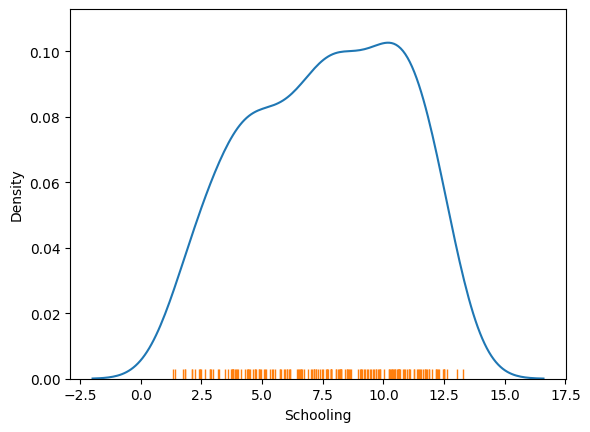

In [19]:
sns.kdeplot(data=life, x="Schooling")
sns.rugplot(data=life, x="Schooling")

Text(0, 0.5, 'Infant_deaths')

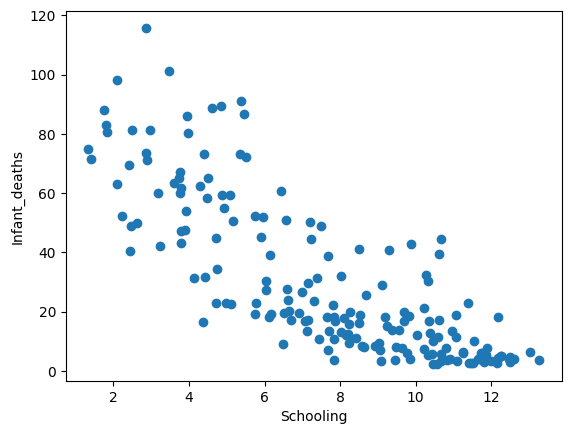

In [20]:
plt.scatter(life['Schooling'] , life['Infant_deaths'],)

plt.xlabel("Schooling")
plt.ylabel("Infant_deaths")

The scatterplot has an obvious negative skew, however it's clear the data is more spread apart with lower levels of schooling, which could tell us that schooling may not be the primary factor of infant deaths. However, at higher levels of average education in a country, the correlation (not causation) between schooling and education seem a lot more certain.

## **Constructing The Linear Model**

In [21]:

with pm.Model() as model_vvba:

    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 1)
    m = pm.Deterministic('m',α + β * life.Schooling.values)

    y = pm.Normal("y_pred",
                  mu=m,
                  sigma=σ,
                  observed=life['Infant_deaths'])
    idata_vvba = pm.sample()

Output()

Output()

In [ ]:
az.rhat(idata_vvba) #not sure why I need to do this, but I'm kind of just following what I did on the excercises. When I remove this block of code, the rest of my code didn't wanna work so it's here to stay!
az.plot_trace(idata_vvba)

az.plot_posterior(idata_vvba)
pm.sample_posterior_predictive(idata_vvba, model=model_vvba, extend_inferencedata=True)
az.plot_ppc(idata_vvba, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])

Text(0, 0.5, 'Infant_deaths')

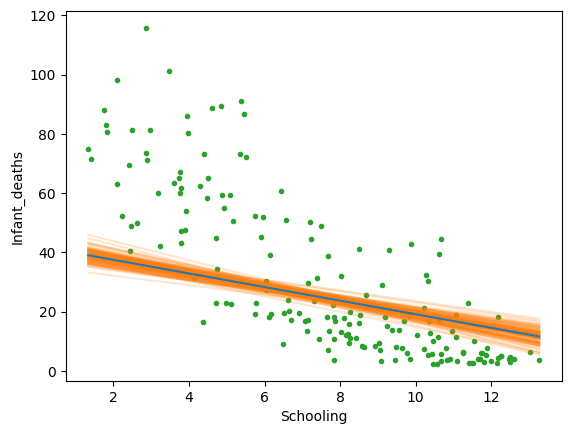

In [24]:
posterior = az.extract(idata_vvba, num_samples=100)

x_plot = xr.DataArray(
    np.linspace(life.Schooling.min(), life.Schooling.max(), 50),
    dims="plot_id"
    )

mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

lines = posterior["α"] + posterior["β"] * x_plot

_, ax = plt.subplots()

ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

ax.plot(x_plot, mean_line, c="C0", label="mean line")

ax.plot(life.Schooling, life.Infant_deaths, "C2.", zorder=-3)

ax.set_xlabel("Schooling")
ax.set_ylabel("Infant_deaths")


So clearly a linear model will not work. It's like it's focusing on 2 seperate parts of the graph and ended up modelling neither trying to compensate. The first half of the graph has a steep slope and the second half of the graph has a flatter slope, and so the only way to model such a transition is modeling a non-linear model. Exponential decay, maybe?

Text(0, 0.5, 'Infant_deaths')

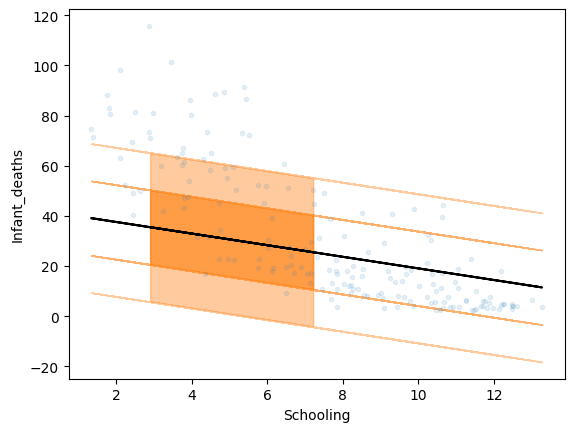

In [26]:
_, ax = plt.subplots()

ax.plot(life.Schooling, life.Infant_deaths, "C0.", alpha=0.1)
posterior_ = az.extract(idata_vvba)

m_m = posterior_["m"].mean("sample").values
σ_m = posterior_["σ"].mean("sample").values

ax.plot(life.Schooling, m_m, c="k")
ax.fill_between(life.Schooling, m_m + 1 * σ_m, m_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(life.Schooling, m_m + 2 * σ_m, m_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("Schooling")
ax.set_ylabel("Infant_deaths")

 This shows the uncertainty the model has as the model's slope drastically changes, showing that while education improves outcomes, some variability remains, likely due to other factors. Because of this, the model cannot be completely linear.

In [27]:
with pm.Model() as goodquestion:

    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=10)

    m = pm.Deterministic("m", pm.math.exp(α + β * life.Schooling))

    σ = pm.HalfNormal("σ", 10)

    y_pred = pm.NegativeBinomial("y_pred", mu=m, alpha=σ, observed=life.Infant_deaths)

    greatquestion = pm.sample(target_accept=0.99)


Output()

Output()

array([[<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

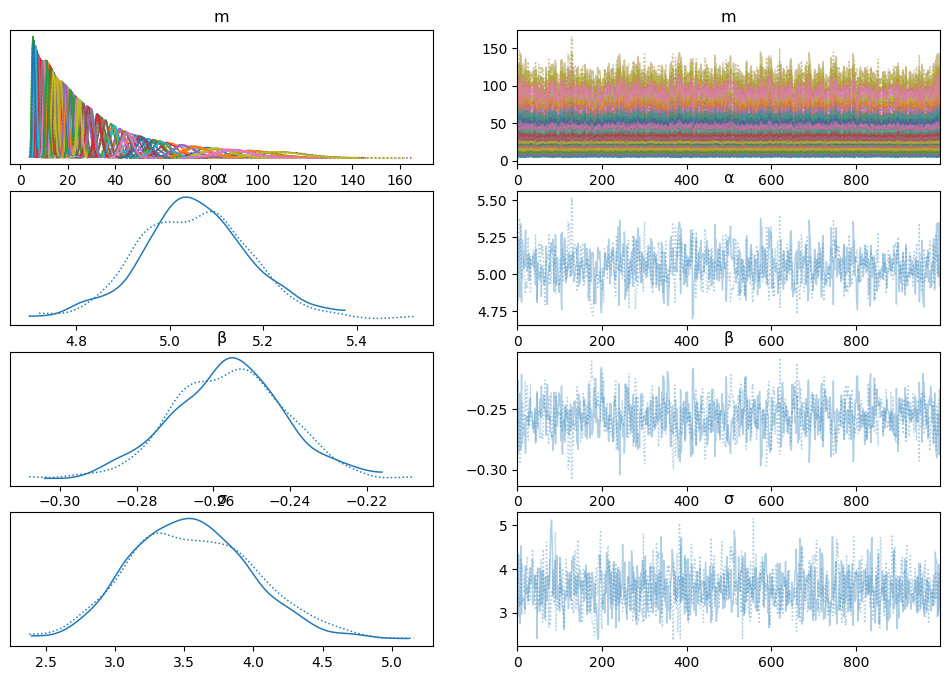

In [28]:
az.rhat(greatquestion)
az.plot_trace(greatquestion)

Output()

<Axes: xlabel='y_pred'>

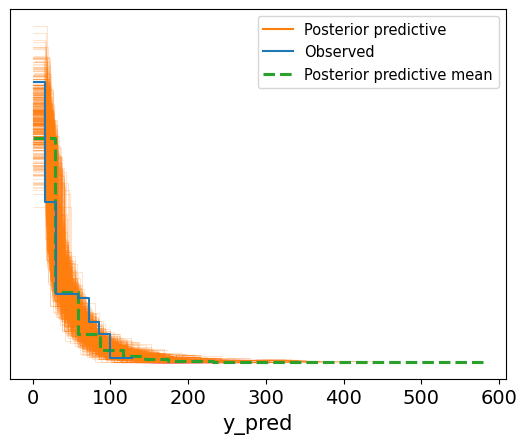

In [29]:
pm.sample_posterior_predictive(greatquestion, model=goodquestion, extend_inferencedata=True)
az.plot_ppc(greatquestion, num_pp_samples= 500, colors=["C1", "C0", "C2"])

That looks like a pretty good fit! This model should be pretty good. Let's graph out the linear regression below.

Text(0, 0.5, 'Infant_deaths')

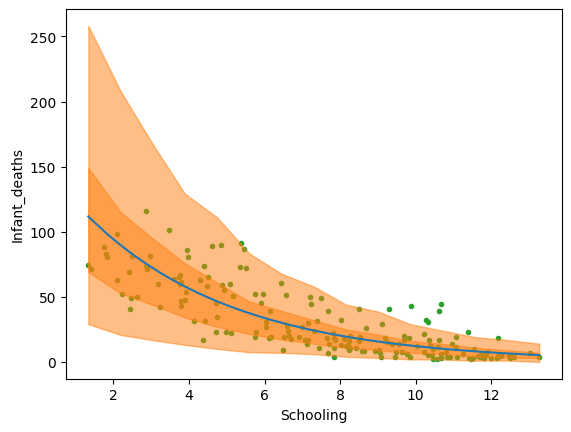

In [30]:
mean_line = greatquestion.posterior["m"].mean(("chain", "draw"))
Schooling = np.random.normal(life.Schooling.values, 0.01)
idx = np.argsort(Schooling)
x = np.linspace(Schooling.min(), Schooling.max(), 15)
y_pred_q = greatquestion.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"] #no idea what these numbers mean got them from the notes
)
y_hat_bounds = iter(
    [
        PchipInterpolator(Schooling[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(life.Schooling, life.Infant_deaths, "C2.", zorder=-3)
ax.plot(life.Schooling[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Schooling")
ax.set_ylabel("Infant_deaths")


I think this is a pretty good model! Most of the data points are within the shaded regions, and the shape matches very well to the points on the scatterplot. There is an obvious negative correlation between infant death rates and schooling as I had thought, but I'll get more into the details in the conclusion.

## **Final Thoughts**

This was a pretty cool study in my opinion. The coolest thing we uncovered from here was definitely the increase in variability as schooling rates in a coutnry/region is lower. I think there are multiple factors for this:



---


# **Factor 1: Overlapping Challenges**

Overlapping Socioeconomic Challenges
While schooling plays a key role in improving health knowledge and child-nurturing, many other factors likely contribute to infant mortality, causing extra variability within the model. For example:


*   Poverty: Low schooling levels often correlate with poverty, which limits access to proper nutrition, medical care, and safe living conditions, all of which can lead to higher infant mortality.
*   Healthcare Access: Countries or regions with low education levels may also lack adequate healthcare infrastructure, such as hospitals, clinics, or trained professionals.
*   Crime: Although extreme, high crime rates or social instability often occur in areas with lower education levels, which could indirectly contribute to poor health outcomes for infants due to unsafe environments or displacement.


These overlapping challenges suggest that education is one part of a broader system influencing child survival, and these factors are more variable when schooling is lower.

---

# **Factor 2: Cultural Factors**

In some regions, cultural values priorities may play a role in lower schooling rates while maintaining relatively low infant mortality. For example:

*   Agricultural Societies: In agricultural economies, formal schooling may be not as prioritized in favor of teaching practical farming skills that support family income. However, if these communities have strong traditional family structures and local knowledge about child-rearing and health, infant mortality could remain relatively low.
*   Maybe societies that are still nomadic, which often means little schooling, are not subject to common illnesses that are detrimintal to infants or find enough food to not die from starvation.

Perhaps lower schooling does not always imply poor health outcomes; the relationship depends on cultural context and alternative systems of knowledge.

---


# **Foctor 3: Structural Inequalities**

In countries with lower schooling, systemic issues such as govt. instability, corruption, and terrible unemployment benefits may worsen health and economic outcomes. These regions might experience higher variability in infant mortality because certain areas may have some access to govt. benefits, while others remain neglected.

---


# **Conclusion:**
Overall, while this study shows a clear negative relationship between schooling levels and infant mortality, the variability highlights that education interacts with many other factors, such as poverty, healthcare access, cultural practices, and systemic inequalities. Addressing infant mortality, especially in regions with low schooling, likely requires a holistic approach that tackles much more than education levels.






